In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

In [3]:
df = pd.read_csv('data/20_newsgroup.csv')

In [4]:
df.head()

,Unnamed: 0,text,target,title,date
0,0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,2021-12-18 14:41:06.564603
1,7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey,2021-12-18 14:41:06.564603
2,8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey,2021-12-18 14:41:06.564603
3,24,I don't know the exact coverage in the states....,10,rec.sport.hockey,2021-12-18 14:41:06.564603
4,44,Here are the NHL's alltime leaders in goals an...,10,rec.sport.hockey,2021-12-18 14:41:06.564603


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18846 non-null  int64 
 1   text        18466 non-null  object
 2   target      18846 non-null  int64 
 3   title       18846 non-null  object
 4   date        18846 non-null  object
dtypes: int64(2), object(3)
memory usage: 736.3+ KB


In [6]:
df.duplicated(subset=['text']).sum()

559

In [7]:
df = df.drop_duplicates(subset=['text'], keep="first")
df.duplicated(subset=['text']).sum()

0

In [8]:
df['target'].value_counts()

10    980
15    975
8     967
5     966
3     965
11    962
13    959
9     957
12    954
1     954
14    953
6     942
2     941
7     937
4     928
17    918
16    887
0     780
18    756
19    606
Name: target, dtype: int64

In [9]:
df.isna().sum()

Unnamed: 0    0
text          1
target        0
title         0
date          0
dtype: int64

In [10]:
df[df['text'].isna()]

,Unnamed: 0,text,target,title,date
10,127,NaN,10,rec.sport.hockey,2021-12-18 14:41:06.564603


In [11]:
df = df.dropna(subset = ['text'])

In [12]:
df['text'][1000]

"\nThink!\n\nIt's the SCSI card doing the DMA transfers NOT the disks...\n\nThe SCSI card can do DMA transfers containing data from any of the SCSI devices\nit is attached when it wants to.\n\nAn important feature of SCSI is the ability to detach a device. This frees the\nSCSI bus for other devices. This is typically used in a multi-tasking OS to\nstart transfers on several devices. While each device is seeking the data the\nbus is free for other commands and data transfers. When the devices are\nready to transfer the data they can aquire the bus and send the data.\n\nOn an IDE bus when you start a transfer the bus is busy until the disk has seeked\nthe data and transfered it. This is typically a 10-20ms second lock out for other\nprocesses wanting the bus irrespective of transfer time.\n"

In [13]:
titles = df['title'].unique()
print(titles)

['rec.sport.hockey' 'comp.sys.ibm.pc.hardware' 'talk.politics.mideast'
 'comp.sys.mac.hardware' 'sci.electronics' 'talk.religion.misc'
 'sci.crypt' 'sci.med' 'alt.atheism' 'rec.motorcycles' 'rec.autos'
 'comp.windows.x' 'comp.graphics' 'sci.space' 'talk.politics.guns'
 'misc.forsale' 'rec.sport.baseball' 'talk.politics.misc'
 'comp.os.ms-windows.misc' 'soc.religion.christian']


Roughly 6 topics: computers, recreation/sports, science, politics, religion and misc.

In [14]:
from bs4 import BeautifulSoup
import re

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def text_preprocessor(text):
    # Strip html text
    soup = BeautifulSoup(text, "lxml")
    data = soup.get_text()
    # Lower case all text
    data = data.lower()
    # Remove edge cases with multiple periods
    pattern = re.compile(r'\s+')
    data = re.sub(pattern, ' ', data.replace('.', ' '))
    # Remove punctuation and other special characters
    pattern = r'[^a-zA-Z\s]'
    data = re.sub(pattern, '', data)
    # Tokenize
    data = word_tokenize(data)
    # Get list of nltk's stopwords
    stopwords_list = stopwords.words('english')
    # Remove stop words
    data = [word for word in data if word not in stopwords_list]
    # Initialize a WordNetLemmatizer object
    wordnet_lemmatizer = WordNetLemmatizer()
    # Convert the tokens into their lemma
    data = [wordnet_lemmatizer.lemmatize(token) for token in data]
    # Convert the list of words back into
    # a string by joining each word with a space
    data = ' '.join(data)
    # Remove double spaces
    data = data.replace('  ', ' ')
    # Remove opening and trailing spaces
    data = data.strip()
    # Return the cleaned text data
    return data

In [15]:
df.text = df.text.apply(text_preprocessor)

/Users/dan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/bs4/__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [16]:
print(df.text[:5])

0    sure bashers pen fan pretty confused lack kind...
1    stuff deleted ok here solution problem move ca...
2    yeah second one believe price ive trying get g...
3    dont know exact coverage state canada covered ...
4    nhls alltime leader goal point end season much...
Name: text, dtype: object


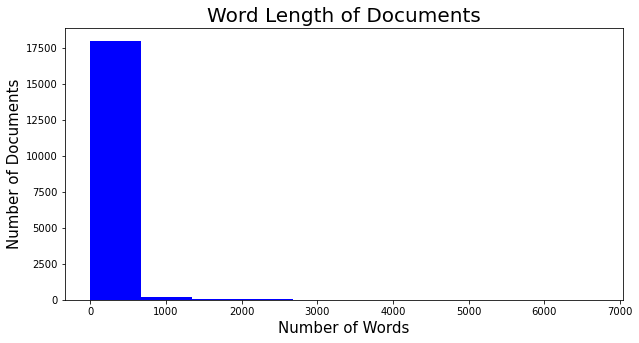

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
length_docs = df['text'].str.split().map(lambda x: len(x))
ax.hist(length_docs, color='blue')
ax.set_title('Word Length of Documents', fontsize=20)
ax.set_ylabel('Number of Documents', fontsize=15)
ax.set_xlabel('Number of Words', fontsize=15)
plt.show()

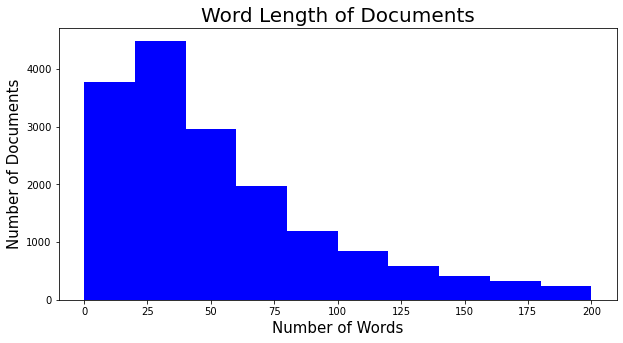

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
length_docs = df['text'].str.split().map(lambda x: len(x))
ax.hist(length_docs, color='blue', range=(0,200))
ax.set_title('Word Length of Documents', fontsize=20)
ax.set_ylabel('Number of Documents', fontsize=15)
ax.set_xlabel('Number of Words', fontsize=15)
plt.show()

/Users/dan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Mean Word Length')

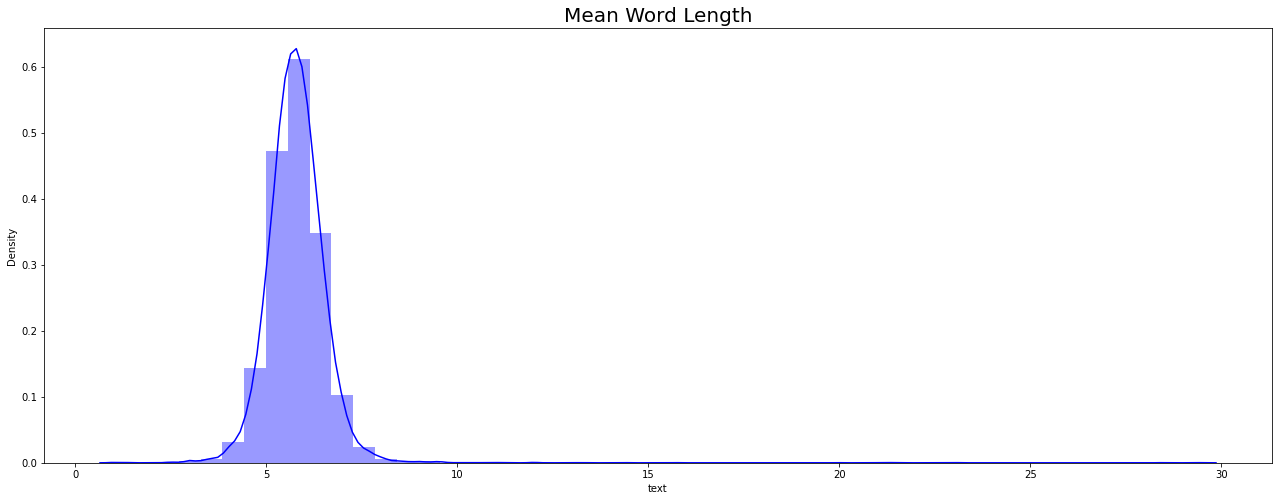

In [19]:
fig, ax = plt.subplots(figsize=(22, 8))
mean_word_length = df['text'].str.split().apply(lambda x: [
    len(i) for i in x])
sns.distplot(mean_word_length.map(lambda x: np.mean(x)), ax=ax, color='blue')
ax.set_title('Mean Word Length', fontsize=20)

In [20]:
def get_all_words(text):
    words = []
    for x in text:
        for y in x.split():
            words.append(y.strip())
    return words
all_words = get_all_words(df.text)
all_words[:10]

['sure',
 'bashers',
 'pen',
 'fan',
 'pretty',
 'confused',
 'lack',
 'kind',
 'post',
 'recent']

In [21]:
from collections import Counter
counter = Counter(all_words)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'one': 10659,
 'would': 10083,
 'x': 7568,
 'people': 6443,
 'like': 6425,
 'dont': 6388,
 'get': 6297,
 'know': 6183,
 'time': 5640,
 'also': 5538}

In [22]:
len(list(counter))

105178

In [23]:
df['text'][1000]

'think scsi card dma transfer disk scsi card dma transfer containing data scsi device attached want important feature scsi ability detach device free scsi bus device typically used multitasking o start transfer several device device seeking data bus free command data transfer device ready transfer data aquire bus send data ide bus start transfer bus busy disk seeked data transfered typically m second lock process wanting bus irrespective transfer time'

In [24]:
# POS-tag the lemmatized words
df.text = [nltk.pos_tag(word_tokenize(token)) for token in df.text]

In [25]:
df['text'][1000]

[('think', 'VB'),
 ('scsi', 'JJ'),
 ('card', 'NN'),
 ('dma', 'NN'),
 ('transfer', 'NN'),
 ('disk', 'NN'),
 ('scsi', 'VBP'),
 ('card', 'NN'),
 ('dma', 'NN'),
 ('transfer', 'NN'),
 ('containing', 'VBG'),
 ('data', 'NNS'),
 ('scsi', 'NN'),
 ('device', 'NN'),
 ('attached', 'VBD'),
 ('want', 'JJ'),
 ('important', 'JJ'),
 ('feature', 'NN'),
 ('scsi', 'JJ'),
 ('ability', 'NN'),
 ('detach', 'NN'),
 ('device', 'NN'),
 ('free', 'JJ'),
 ('scsi', 'NN'),
 ('bus', 'NN'),
 ('device', 'NN'),
 ('typically', 'RB'),
 ('used', 'VBD'),
 ('multitasking', 'VBG'),
 ('o', 'JJ'),
 ('start', 'NN'),
 ('transfer', 'VB'),
 ('several', 'JJ'),
 ('device', 'NN'),
 ('device', 'NN'),
 ('seeking', 'VBG'),
 ('data', 'NNS'),
 ('bus', 'RB'),
 ('free', 'JJ'),
 ('command', 'NN'),
 ('data', 'NNS'),
 ('transfer', 'NN'),
 ('device', 'NN'),
 ('ready', 'JJ'),
 ('transfer', 'NN'),
 ('data', 'NNS'),
 ('aquire', 'VBP'),
 ('bus', 'JJ'),
 ('send', 'NN'),
 ('data', 'NNS'),
 ('ide', 'RB'),
 ('bus', 'IN'),
 ('start', 'NN'),
 ('transfer', 

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_weighted_ngrams(text, num_words, ngram):
    vec = TfidfVectorizer(ngram_range=(ngram, ngram)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_weighted = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_weighted = sorted(words_weighted, key=lambda x: x[1], reverse=True)
    return words_weighted[:num_words]

In [27]:
weighted_uni = get_weighted_ngrams(df.text, 20, 1)
weighted_uni = dict(weighted_uni)
temp = pd.DataFrame(columns=["Weighted_words", 'TFIDF_Score'])
temp["Weighted_words"] = list(weighted_uni.keys())
temp["TFIDF_Score"] = list(weighted_uni.values())
fig = px.bar(temp, x="TFIDF_Score", y="Weighted_words", title='Weighted Unigrams', orientation='h',
             width=700, height=700, color='Weighted_words')
fig.show()

AttributeError: 'list' object has no attribute 'lower'

In [ ]:
weighted_bi = get_weighted_ngrams(df.text,20,2)
weighted_bi = dict(weighted_bi)
temp = pd.DataFrame(columns = ["Weighted_words" , 'TFIDF_Score'])
temp["Weighted_words"] = list(weighted_bi.keys())
temp["TFIDF_Score"] = list(weighted_bi.values())
fig = px.bar(temp, x="TFIDF_Score", y="Weighted_words", title='Weighted Bigrams', orientation='h', 
             width=700, height=700,color='Weighted_words')
fig.show()

## Modeling

### Model-less Baseline

In [ ]:
df.title.value_counts(normalize=True)

Our model-less baseline says...

In [30]:
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter

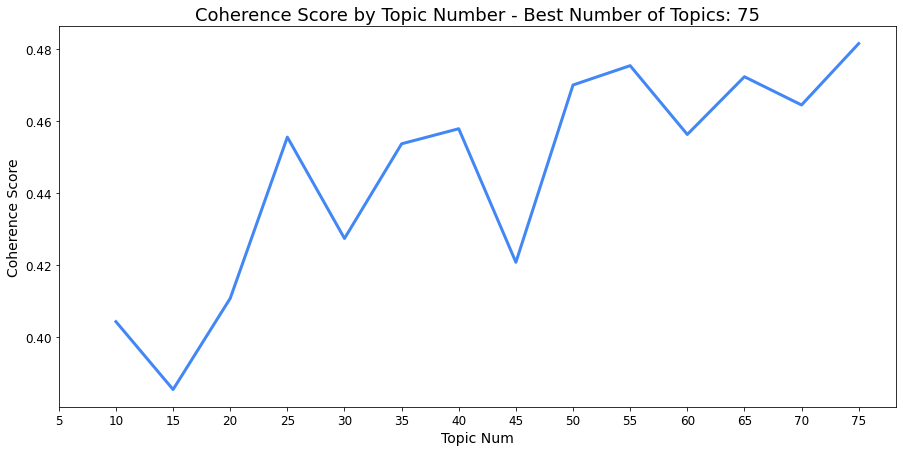

In [34]:
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter

# Use NMF to get the best number of topics via coherence score
texts = df['text']
texts = [str(d).split() for d in texts]

# Create a dictionary
dictionary = Dictionary(texts)

# Limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=50000
)

# Create the bag-of-words format
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers within a range of 10-30, step 2
topic_nums = list(np.arange(10, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()


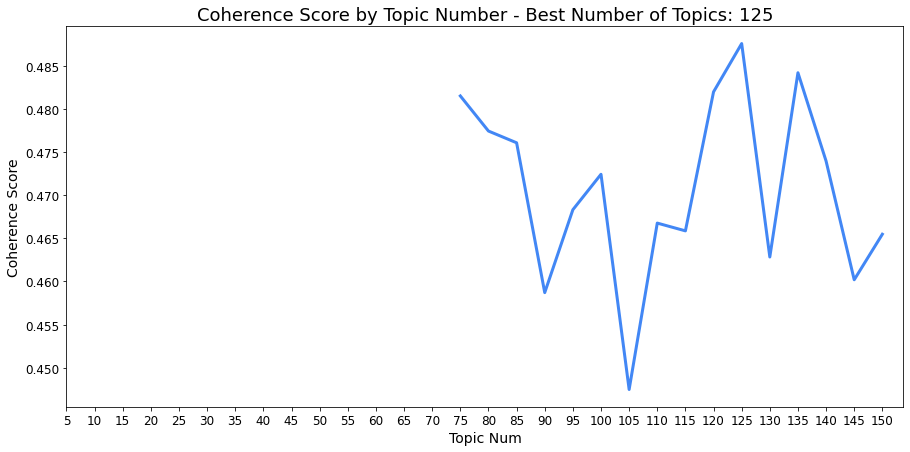

In [35]:
# Use NMF to get the best number of topics via coherence score
texts = df['text']
texts = [str(d).split() for d in texts]

# Create a dictionary
dictionary = Dictionary(texts)

# Limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=50000
)

# Create the bag-of-words format
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers within a range of 10-30, step 2
topic_nums = list(np.arange(75, 150 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()


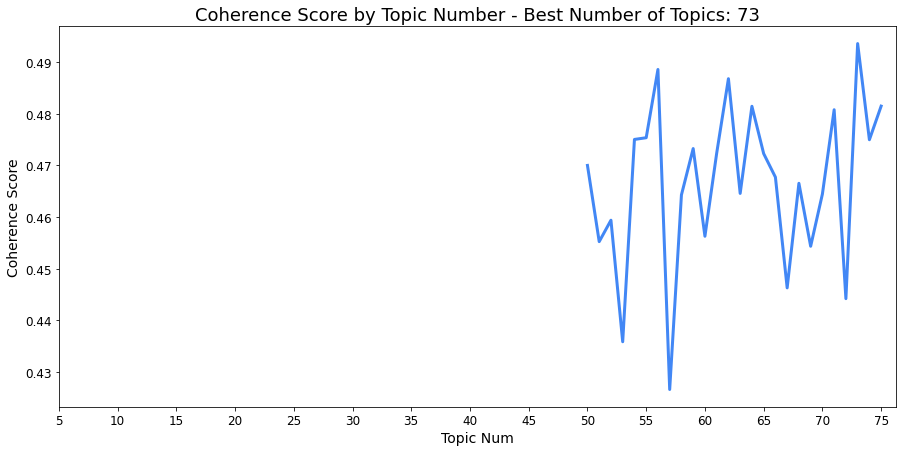

In [36]:
# Use NMF to get the best number of topics via coherence score
texts = df['text']
texts = [str(d).split() for d in texts]

# Create a dictionary
dictionary = Dictionary(texts)

# Limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=50000
)

# Create the bag-of-words format
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers within a range of 10-30, step 2
topic_nums = list(np.arange(50, 75 + 1, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

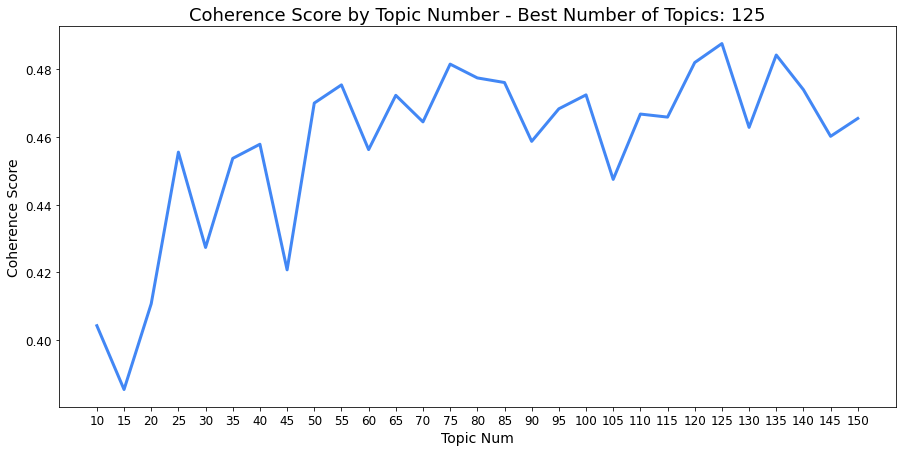

In [37]:
# Use NMF to get the best number of topics via coherence score
texts = df['text']
texts = [str(d).split() for d in texts]

# Create a dictionary
dictionary = Dictionary(texts)

# Limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=30000
)

# Create the bag-of-words format
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers within a range of 10-30, step 2
topic_nums = list(np.arange(10, 150 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(10, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

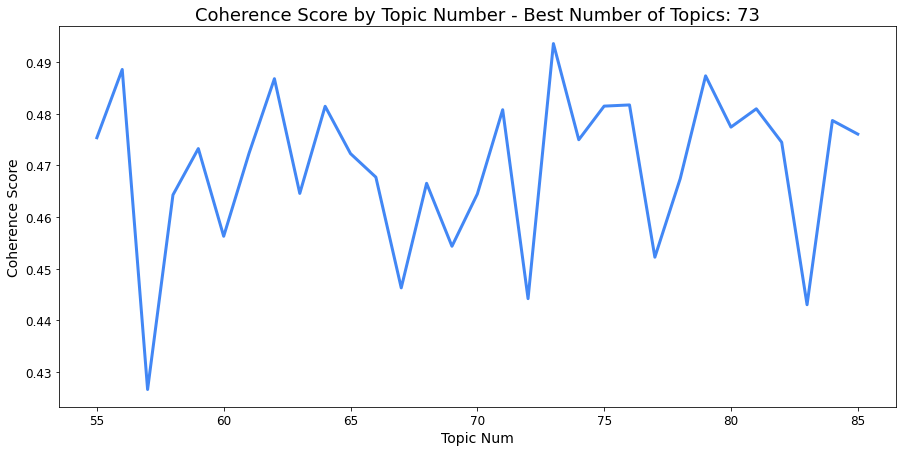

In [38]:
# Use NMF to get the best number of topics via coherence score
texts = df['text']
texts = [str(d).split() for d in texts]

# Create a dictionary
dictionary = Dictionary(texts)

# Limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=30000
)

# Create the bag-of-words format
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers within a range of 55-85, step 1
topic_nums = list(np.arange(55, 85 + 1, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(55, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [43]:
# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model

texts = df['text']
texts = [str(d).split() for d in texts]

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=30000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
feature_names = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=73,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [44]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

NameError: name 'topic_table' is not defined